In [1]:
# Matematica Simbolica
import sympy as sp

# Manejar la salida de jupyter lab
from IPython.display import clear_output, display, HTML, Math, Markdown

# Manejo de tablas
import pandas as pd

# Diccionario con valor por defecto
from collections import defaultdict

# Para manejar JSON
import json

# Manejo de Matrices y vectores
import numpy as np

# Asincronia
from threading import Thread

import matplotlib.pyplot as plt
from pprint import pprint
import matplotlib
%matplotlib agg
matplotlib.style.use('seaborn')
plt.ioff()
##### Codigos de estilo #####
DO_NOTHING   = 0x1
PROPERTIES   = 0x2
RANGE        = 0x4
DOMAIN       = 0x8
DERIVATIVE   = 0x10
INTEGRAL     = 0x20
EXPANDED     = 0x40
SIMPLIFIED   = 0x80
FACTORIZE    = 0x100
ROOTS        = 0x200
INVERSE      = 0x400
ALT_INVERSE  = 0x800
CRIT_POITNS  = 0x1000
MONOTONIA    = 0x2000
GRAFICO      = 0x4000
# AGREGA AQUI NUEVOS ESTILOS



#######################

# Latex Expressions ###
# Plantillas para la derivada e integral
DERIVATIVE_LATEX = "\\frac{d}{dx}(%s)=\\text{  }"
INTEGRAL_LATEX = "\\displaystyle\\int (%s) dx = \\text{  }"
# La lista de los nombres de los grados de los polinomios
DEGREES = ['Constante', 'Lineal', 'Cuadratica', 'Cubica']
######################

### GUI CONSTANTS ###
# Para saber cuantos carácteres se ingresarón en el input
HITS = 10
#####################

# Los simbolos, reemplazan el valor de x o y automaticamente en la función
x, y, m = sp.symbols("x, y, m")
# Cargamos el archivo de configuración
with open("settings.json", 'r', encoding='utf8') as f:
    settings = json.load(f)
# Inyectar CSS en jupyter notebook
HTML(settings["style"])

In [2]:
# Recibir entrada del usuario
def input_expr(result_dict):    
    print("Ingrese una expresion")
    user_input = input()
    clear_output()
    # Convertir una expresión en forma de cadena a Sympy
    expr = sp.parsing.sympy_parser.parse_expr(user_input, evaluate=False)
    result_dict['fx'] = expr
    return expr

# Forma expandida
def expand_form(fy, result_dict):
    expanded = fy.expand()
    if expanded != fy.simplify() and fy != expanded:
        result_dict["expanded"] = expanded

# Forma simplificada
def simplify_form_xy(fy, result_dict):
    simple = fy.simplify()
    if sp.latex(simple) != sp.latex(fy)\
    and simple != result_dict['expanded']\
    and sp.latex(simple) != sp.latex(fy.expand()):
        result_dict["simple"] = simple
    

# Tipo de función
def polynomial(fy, result_dict):
    if fy.is_algebraic:
        result_dict['f_type'] = "Algebraica"
    
    if fy.is_polynomial() and fy.free_symbols:
        result_dict['f_type'] = "Polinomica"
        return sp.Poly(fy)
    
    if fy.is_rational_function():
        result_dict['f_type'] = "Racional"
    
    
    return None

def is_constant(fy, result_dict):
    result_dict['constant'] = fy.is_constant()

def recursive_dict_organization(key, result_dict, l):
    if len(l) == 0: 
        return
    el = l.pop()

    result_dict[key].append(el)
    return recursive_dict_organization(key, result_dict, l)

# Raices
def extract_roots(fy_poly, result_dict, r=None):
    if fy_poly:
        if r == None:
            r = sp.nroots(fy_poly)
        if len(r) <= 0:
            return fy_poly
        root = r.pop()
        if sp.im(root) == 0:
            result_dict["real_roots"].append(root)
        else:
            result_dict["complex_roots"].append(root)
        return extract_roots(fy_poly, result_dict, r)
    else:
        return

# Si hay una factirizacion 
def factorization(fy, result_dict):
    factor = sp.factor(fy)
    if sp.latex(factor) != sp.latex(fy)\
    and sp.latex(factor) != sp.latex(fy.simplify()):
        result_dict['factor'] = factor
    return result_dict

# El grado
def get_degree(degree):
    if degree < 4:
        return DEGREES[degree]
    else:
        return f"{degree} Grado"

# Información extra
def poly_kit(fy, fy_poly, result_dict):
    if fy.free_symbols:
        inverse = sp.solve(fy, x)
        recursive_dict_organization('inverse', result_dict, inverse)
        result_dict['domain'] = sp.calculus.util.continuous_domain(fy, x, sp.Reals)
        result_dict['range'] = sp.calculus.util.function_range(fy, x, sp.Reals)
        result_dict['derivative'] = fy.diff()
        result_dict['integral'] = sp.integrate(fy)
        result_dict['degree'] = fy_poly.degree()
        result_dict['degree_text'] = get_degree(result_dict['degree'])
        
# Limpia el diccionario y valor en RAM
def clean_result(res):
    if not res['expanded']:
        del res['expanded']

# crea una etiqueta en Latex
def latex_label(label, content):
    label = "\\text{%s}: " % label
    return Math(label + sp.latex(content))

# Maquina de estado finito
# Concepto de Alan Turing
def latex_format(content, style):
    pack = []
    if style & DO_NOTHING:
        pack.append(Math(sp.latex(content)))
    if style & PROPERTIES:
            
        data = {
                    'Tipo de función': content['f_type'],
                    'Es Constante': "Sí" if content['constant'] else "No"
                }
        if content['degree']:
            data.update({
                "Tipo de Polinomio": content['degree_text']
            })

        pack.append(pd.DataFrame(data, index=["Propiedad"]).T)

    if style & DOMAIN:
        pack.append(latex_label('Dominio', content['domain']))
    if style & RANGE:
        pack.append(latex_label('Rango', content['range']))
        
    if style & DERIVATIVE:
        derivative = DERIVATIVE_LATEX % sp.latex(content['fx'])
        pack.append(Math(derivative + sp.latex(content['derivative'])))
    if style & INTEGRAL:
        integral = INTEGRAL_LATEX % sp.latex(content['fx'])
        pack.append(Math(integral + sp.latex(content['integral'])))
    
    if style & EXPANDED:
        if content['expanded']:
            pack.append(Math(sp.latex(content['expanded'])))
            
    if style & SIMPLIFIED:
        if content['simple']:
            pack.append(Math(sp.latex(content['simple'])))
    
    if style & FACTORIZE:
        if content['factor']:
            pack.append(Math(sp.latex(content['factor'])))
        
    if style & ROOTS:
        if content['real_roots']:
            pack.append(HTML('<br/><p>Raíces reales</p>'))
            for i in content['real_roots']:
                pack.append(Math("x \\approx %s" % sp.latex(i)))
        if content['complex_roots']:
            pack.append(HTML('<br/><p>Raíces complejas</p>'))
            for i in content['complex_roots']:
                pack.append(Math("x \\approx %s" % sp.latex(i)))
    
    if style & INVERSE:
        if content['inverse']:
            f_inverse = sp.latex(content['inverse'].pop())
            pack.append(Math(f_inverse))
    
    if style & ALT_INVERSE:
        if content['inverse']:
            for i in content['inverse']:
                pack.append(Math(sp.latex(i)))
    
    if style & CRIT_POITNS:
        if content['critical_points']:
            for i in content['critical_points']:
                pack.append(Math("x = %s \\, (\\text{ %s })" % (sp.latex(i['x']), i['es_un'])))
   
    if style & MONOTONIA:
        if isinstance(content['monotonia'], dict):
            tabla = pd.DataFrame({"Monotonia": content['monotonia'].values()},
                                 index= content['monotonia'].keys())
            mark = tabla.to_markdown()
            pack.append(Markdown(mark))
        else:
            pack.append(Math(content['monotonia']))
    
    if style & GRAFICO:
        if content['grafico']:
            pack.append(content['grafico'])
        else:
            pass
    # AGREGA AQUI TU CONDICION
    # Este es nuestro nuevo trozo de codigo
    return pack

    


# Analiza los puntos criticos
def analizer(fy, result_dict):
    r_dict = []
    dy = fy.diff()
    ddy = dy.diff()
    extremo = sp.solve(sp.Eq(dy, 0))
    for val in extremo:
        dy_res = ddy.subs(x, val)
        if dy_res == 0:
            r_dict.append({"x": dy_res, "es_un": "Punto de infexión"})
        elif dy_res > 0:
            r_dict.append({"x": dy_res, "es_un": "Punto minimo"})
        elif dy_res < 0:
            r_dict.append({"x": dy_res, "es_un": "Punto maximo"})

            
    result_dict['critical_points'] = r_dict

def obtener_intervalos(lista, loop_1=True, intervalos=[]):
    if len(lista) == 0:
        return intervalos
    
    if loop_1:
        intervalo = sp.Interval.open(-sp.oo, lista[0])
        intervalos.append(intervalo)
        return obtener_intervalos(lista, False, intervalos)
    
    if len(lista) > 1:
        intervalo = sp.Interval.open(lista.pop(0), lista[0])
        intervalos.append(intervalo)
        
        return obtener_intervalos(lista, False, intervalos)

    if len(lista) == 1:
        intervalo = sp.Interval.open(lista.pop(0), sp.oo)
        intervalos.append(intervalo)

        return obtener_intervalos(lista, False, intervalos)

def analizar_intervalos(intervalos, derivada, delta=1, res={}):
    if len(intervalos) == 0:
        return res
    intervalo = intervalos[0]
    signo = 1
    if intervalo.start == -sp.oo:
        valor = intervalo.end.evalf() - delta
        signo = sp.sign(derivada.subs(x, valor))
    elif intervalo.end == sp.oo:
        valor = intervalo.start.evalf() + delta
        signo = sp.sign(derivada.subs(x, valor))
    else:
        valor = intervalo.start + delta

        if intervalo.contains(valor):
            signo = sp.sign(derivada.subs(x, valor))
        else:
            return analizar_intervalos(intervalos, derivada,delta/10, res)
    intervalos.pop(0)
    if signo == -1:
        res.update({f"${sp.latex(intervalo)}$": "Decreciente"})
    else:
        res.update({f"${sp.latex(intervalo)}$": "Creciente"})
    return analizar_intervalos(intervalos, derivada, 1, res)


def intervalos_de_monotonia(fy, fy_poly, result_dict):
    degree = fy_poly.degree()
    if not degree > 4:
        # Obtenemos la primera derivada
        # Respecto a x
        derivada = sp.diff(fy, x)
        # Resolvemos la derivada en la intersección
        ecuacion = sp.Eq(derivada, 0)
        # Obtenemos las soluciones
        soluciones = sp.solve(ecuacion)
        # Filtramos y ordenamos las soluciones
        soluciones = list(filter(lambda x: x.is_real, soluciones))
        soluciones.sort()
        # Analizar los intervalos
        if len(soluciones) > 0:
            intervalos = obtener_intervalos(soluciones)
            resultado = analizar_intervalos(intervalos, fy.diff(x))
            result_dict['monotonia'] = resultado
        else:
            result_dict['monotonia'] = r"\text{No se pudo analizar la función.}"



# Genera un elemento
def generate_element(title, content, style, gui):
    fmt = latex_format(content, style)
    if fmt:
        gui += [HTML(f"<h4>{title}</h4>"), *fmt, HTML(settings['hr'])]

# Graficar una función       
def plot_function(fy, line_color="red", point_color="blue", ax=None):
    python_fy = sp.lambdify(x, fy)
    func_range = (-10, 10)
    fy_x = np.arange(*func_range)
    fy_y = python_fy(fy_x)

        
    ax.plot(fy_x, fy_y, c=line_color)
    ax.scatter(fy_x, fy_y, c=point_color)


# Graficar la funcion, derivada e integral
def graficar(fy, result_dict):
    fig = plt.figure(figsize=(15, 4))
    (ax1, ax2, ax3) = fig.subplots(1, 3)
    ax1.set_title("Grafico de f(x)")
    ax1.set_xlabel("x")
    ax1.set_ylabel("f(x)")
    ax2.set_title("Grafico de f\'(x)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("f'(x)")
    ax3.set_title("Grafico de la integral de f(x)")
    ax3.set_xlabel("x")
    ax3.set_ylabel("(integral f)(x)")
    plot_function(fy, line_color="#8A4FFF", point_color="#64f58d", ax=ax1)
    plot_function(fy.diff(), line_color="#DB162F", point_color="#3B1F2B", ax=ax2)
    plot_function(sp.integrate(fy), line_color="#F6AA1C", point_color="#29339B", ax=ax3)

    result_dict['grafico'] = fig

# AGREGA NUEVAS FUNCIONES
        


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Propiedad
Tipo de función    Polinomica
Es Constante               No
Tipo de Polinomio  Cuadratica

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

|                           | Monotonia   |
|:--------------------------|:------------|
| $\left(-\infty, 0\right)$ | Decreciente |
| $\left(0, \infty\right)$  | Creciente   |

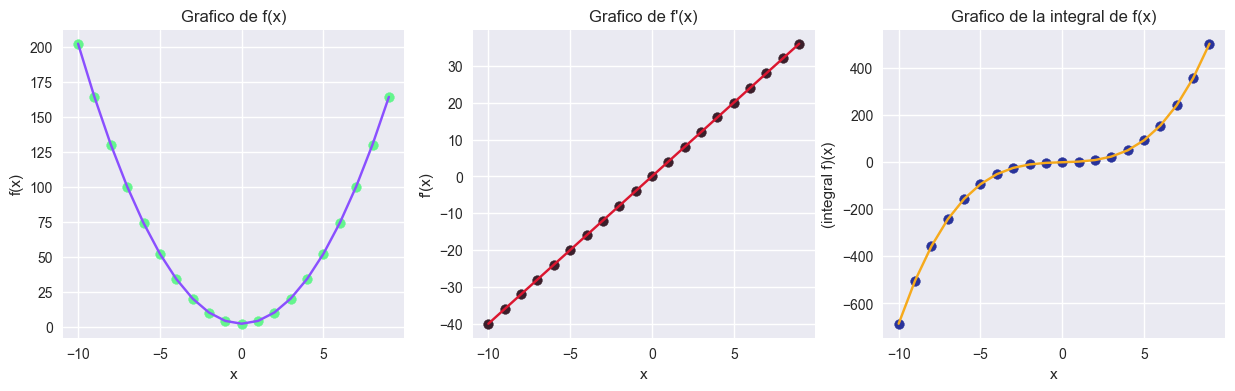

In [3]:
# Punto de entrada al programa
result_dict = defaultdict(list) # Si no se le da un elemento por defecto crea una lista
fy = input_expr(result_dict)
#fy= solve_in_terms_of_y(expr, result_dict)
_ = expand_form(fy, result_dict)
_ = simplify_form_xy(fy, result_dict)
fy_poly = polynomial(fy, result_dict)
_ = is_constant(fy, result_dict)
_ = extract_roots(fy_poly, result_dict)
_ = factorization(fy, result_dict)
_ = poly_kit(fy, fy_poly, result_dict)
_ = intervalos_de_monotonia(fy, fy_poly, result_dict)
try:
    _ = graficar(fy, result_dict)
    _ = analizer(fy, result_dict)
except:
    pass
clean_result(result_dict)
gui = []
# FIN DE LA LINEA DE MONTAJE



# Crea todo el apartado visual
generate_element("Entrada del usuario", result_dict['fx'], DO_NOTHING, gui=gui)
generate_element('Formas Alternativas', result_dict, EXPANDED | SIMPLIFIED | FACTORIZE, gui=gui)
generate_element('Propiedades', result_dict, PROPERTIES | DOMAIN | RANGE, gui=gui)
generate_element('Derivada', result_dict, DERIVATIVE, gui=gui)
generate_element('Integral', result_dict, INTEGRAL, gui=gui)
generate_element('Raices', result_dict, ROOTS, gui=gui)
generate_element('Puntos Criticos', result_dict , CRIT_POITNS, gui=gui)
generate_element('Monotonia', result_dict, MONOTONIA, gui=gui)
generate_element('Graficas de la función', result_dict, GRAFICO, gui=gui)
# FIN DE LA LINEA DE APARTADO VISUAL


display(*gui)
